In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
try:
    data = pd.read_csv('Online-Retail.csv')
except FileNotFoundError:
    print("Error: Dataset file not found. Ensure the file path is correct.")
    exit()

# Check column names
print("Dataset Columns:", data.columns)

# Define column names dynamically
customer_id_col = 'CustomerID'  # Customer ID column
date_col = 'InvoiceDate'        # Invoice date column
invoice_col = 'InvoiceNo'       # Invoice number column
quantity_col = 'Quantity'       # Quantity column
unit_price_col = 'UnitPrice'    # Unit price column

# Ensure all necessary columns are present
required_columns = {customer_id_col, date_col, invoice_col, quantity_col, unit_price_col}
if not required_columns.issubset(data.columns):
    print(f"Error: Dataset must contain the following columns: {required_columns}")
    exit()

# Create 'Amount' column
data['Amount'] = data[quantity_col] * data[unit_price_col]

# Handle missing values
data = data.dropna(subset=[customer_id_col, date_col, 'Amount'])
data[date_col] = pd.to_datetime(data[date_col], errors='coerce')

# Reference date for RFM analysis
reference_date = data[date_col].max() + pd.Timedelta(days=1)

# Perform RFM Analysis
rfm = data.groupby(customer_id_col).agg({
    date_col: lambda x: (reference_date - x.max()).days,  # Recency
    invoice_col: 'count',  # Frequency
    'Amount': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Normalize RFM values using Min-Max Scaling
scaler = MinMaxScaler()
rfm_normalized = rfm.copy()
rfm_normalized[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Save preprocessed datasets
rfm.to_csv('rfm_dataset.csv', index=False)  # Before scaling
rfm_normalized.to_csv('rfm_dataset_normalized.csv', index=False)  # After scaling

# Output: Display the first few rows of each dataset
print("RFM Dataset (Before Scaling):")
print(rfm.head())

print("\nRFM Dataset (After Scaling):")
print(rfm_normalized.head())


Dataset Columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
RFM Dataset (Before Scaling):
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          2      0.00
1     12347.0        2        182   4310.00
2     12348.0       75         31   1797.24
3     12349.0       19         73   1757.55
4     12350.0      310         17    334.40

RFM Dataset (After Scaling):
   CustomerID   Recency  Frequency  Monetary
0     12346.0  0.871314   0.000125  0.015109
1     12347.0  0.002681   0.022676  0.030297
2     12348.0  0.198391   0.003758  0.021442
3     12349.0  0.048257   0.009020  0.021303
4     12350.0  0.828418   0.002005  0.016288


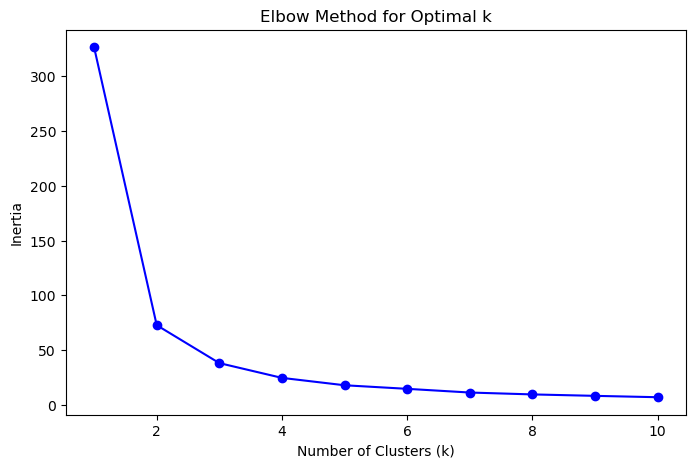

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Features for clustering
X = rfm_normalized[['Recency', 'Frequency', 'Monetary']]

# Elbow method to find optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [5]:
# Based on the Elbow Method, choose an optimal k (replace 'optimal_k' with the chosen number)
optimal_k = 4  # Replace this after analyzing the elbow curve

# Fit K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_normalized['Cluster'] = kmeans.fit_predict(X)

# Save the clustered data
rfm_normalized.to_csv('rfm_clustered_kmeans.csv', index=False)

# Display cluster centroids
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Sample output of clusters
print("Clustered Data (First 10 rows):")
print(rfm_normalized.head(10))


Cluster Centers:
[[0.04664158 0.01820856 0.02603217]
 [0.4944398  0.00430974 0.01721278]
 [0.81866972 0.00276578 0.01638546]
 [0.20834929 0.00660509 0.01860505]]
Clustered Data (First 10 rows):
   CustomerID   Recency  Frequency  Monetary  Cluster
0     12346.0  0.871314   0.000125  0.015109        2
1     12347.0  0.002681   0.022676  0.030297        0
2     12348.0  0.198391   0.003758  0.021442        3
3     12349.0  0.048257   0.009020  0.021303        0
4     12350.0  0.828418   0.002005  0.016288        2
5     12352.0  0.093834   0.011776  0.020555        0
6     12353.0  0.544236   0.000376  0.015423        1
7     12354.0  0.619303   0.007141  0.018913        1
8     12355.0  0.571046   0.001503  0.016728        1
9     12356.0  0.058981   0.007266  0.025016        0


In [9]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm_normalized['DBSCAN_Cluster'] = dbscan.fit_predict(X)

# Save the DBSCAN clustered data
rfm_normalized.to_csv('rfm_clustered_dbscan.csv', index=False)

# Sample output of clusters
print("DBSCAN Clustered Data (First 10 rows):")
print(rfm_normalized.head(10))


DBSCAN Clustered Data (First 10 rows):
   CustomerID   Recency  Frequency  Monetary  Cluster  DBSCAN_Cluster
0     12346.0  0.871314   0.000125  0.015109        2               0
1     12347.0  0.002681   0.022676  0.030297        0               0
2     12348.0  0.198391   0.003758  0.021442        3               0
3     12349.0  0.048257   0.009020  0.021303        0               0
4     12350.0  0.828418   0.002005  0.016288        2               0
5     12352.0  0.093834   0.011776  0.020555        0               0
6     12353.0  0.544236   0.000376  0.015423        1               0
7     12354.0  0.619303   0.007141  0.018913        1               0
8     12355.0  0.571046   0.001503  0.016728        1               0
9     12356.0  0.058981   0.007266  0.025016        0               0


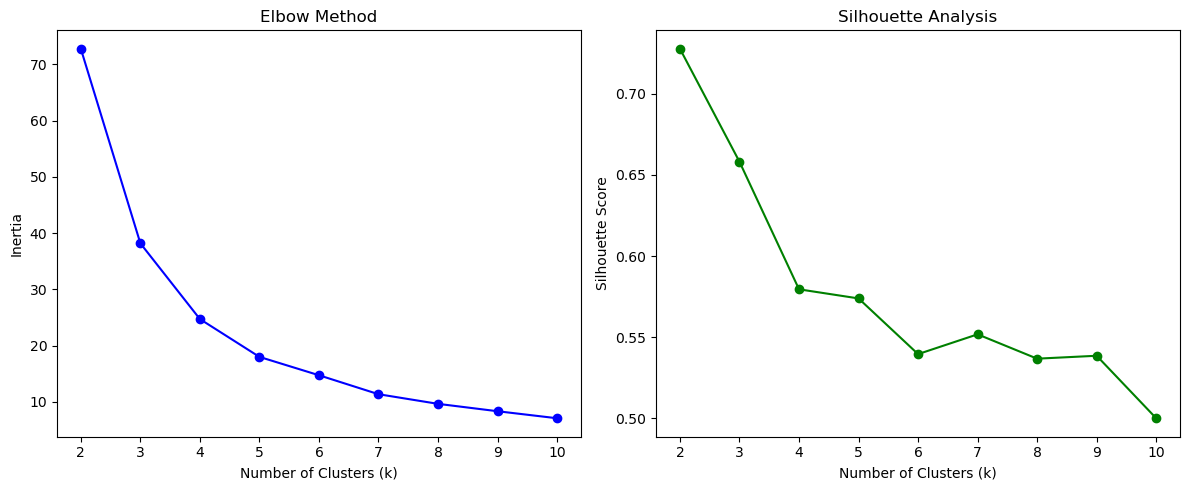

In [13]:
from sklearn.metrics import silhouette_score

# Features for clustering
X = rfm_normalized[['Recency', 'Frequency', 'Monetary']]

# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 11)  # Start from 2 clusters since silhouette score is undefined for k=1

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()


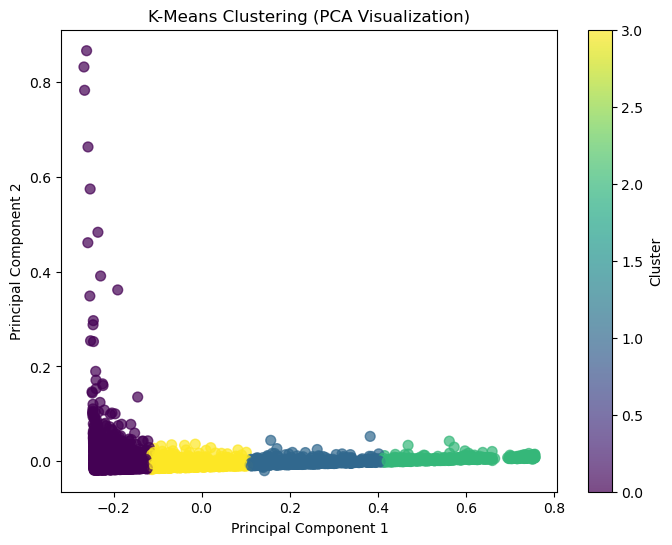

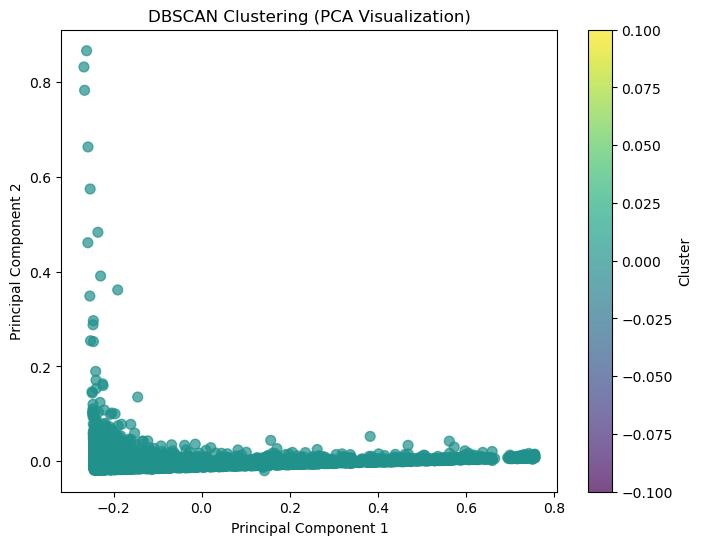

In [19]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot K-Means Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=rfm_normalized['KMeans_Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Plot DBSCAN Clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=rfm_normalized['DBSCAN_Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


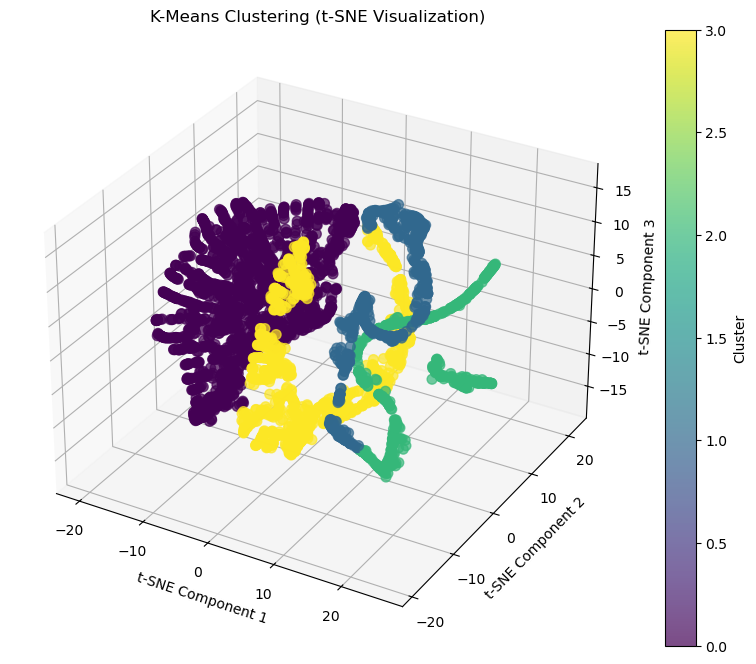

In [21]:
from sklearn.manifold import TSNE

# Apply t-SNE for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)

# 3D Scatter Plot (K-Means)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], 
                      c=rfm_normalized['KMeans_Cluster'], cmap='viridis', s=50, alpha=0.7)
ax.set_title('K-Means Clustering (t-SNE Visualization)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
plt.colorbar(scatter, label='Cluster')
plt.show()


In [22]:
# Analyze cluster characteristics
cluster_summary = rfm.groupby('KMeans_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Cluster Summary:\n", cluster_summary)


KeyError: 'KMeans_Cluster'